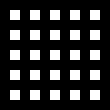

In [1]:
using Images, FFTW, LinearAlgebra: kron
M = 10
N = 10
A = [ i&j&1 for i in 0:N, j in 0:M ] # isodd(i) & isodd(j) & 1
Gray.(A)

In [2]:
cd("C:\\Users\\User\\Desktop\\Mycop")

https://github.com/duckythescientist/SmoothLife

https://0fps.net/2012/11/19/conways-game-of-life-for-curved-surfaces-part-1/

https://www.csun.edu/~kme52026/thesis.html

https://www.conwaylife.com/wiki/Caterpillar


In [3]:
function clamp(x)
	y = copy(x)
	y[x.>1] .= 1
	y[x.<0] .= 0
	y
end

function func_linear(X, a, b)
	Y = [ (x-a + 0.5b)/b for x in X ]

	Y[X.<a-0.5b] .= 0
	Y[X.>a+0.5b] .= 1
	return Y
end

function splat!(aa, ny, nx, ra)
	x = round(Int, rand()*nx ) + 1
	y = round(Int, rand()*ny ) + 1
	c = rand() > 0.5

	for dx = -ra:ra, dy = -ra:ra
		ix = x+dx
		iy = y+dy
		if ix>=1 && ix<=nx && iy>=1 && iy<=ny
			aa[iy,ix] = c
		end
	end
end

function initaa(ny, nx, ra)
	aa = zeros(ny, nx)
	for t in 0:((nx/ra)*(ny/ra))
		splat!(aa, ny, nx, ra);
	end
	aa
end

initaa (generic function with 1 method)

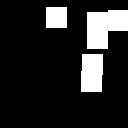

In [30]:
nn = 128
aa = zeros(nn,nn)

for _ in 1:10
    splat!(aa, nn, nn, 10)
end
Gray.(aa)

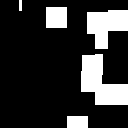

In [31]:
for _ in 1:10
    splat!(aa, nn, nn, 10)
end
Gray.(aa)

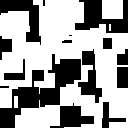

In [33]:
aa = initaa(nn,nn,10)
Gray.(aa)

In [4]:
func_smooth(x::Float64, a, b)  = 1 / ( 1 + exp(-4(x-a)/b) ) 

sigmoid_a(x, a, ea) = func_smooth(x, a, ea)
sigmoid_b(x, b, eb) = 1 - sigmoid_a(x, b, eb)
sigmoid_ab(x, a, b, ea, eb) = sigmoid_a(x, a, ea) * sigmoid_b(x, b, eb)
sigmoid_mix(x, y, m, em) = x - x * func_smooth(m, 0.5, em) + y * func_smooth(m, 0.5, em)

function snm(N, M, en, em, b1, b2, d1, d2)
    
    [ sigmoid_mix( sigmoid_ab(N[i,j], b1, b2, en, en), 
                   sigmoid_ab(N[i,j], d1, d2, en, en), M[i,j], em ) 
                    for i = 1:size(N, 1), j = 1:size(N, 2) ]
end

snm (generic function with 1 method)

In [18]:
function smoothlife(NX = 128, NY = 128, tfin = 10, scheme = 1)
    
    function derivative(aa)
        aaf = fft(aa)
        nf = aaf .* krf
        mf = aaf .* kdf
        n = real.(ifft(nf)) / kflr # irfft
        m = real.(ifft(mf)) / kfld
        2snm(n, m, alphan, alpham, b1, b2, d1, d2) .- 1
    end
    
    ra = 10
    ri = ra/3
    b = 1
    b1 = 0.257
    b2 = 0.336
    d1 = 0.365
    d2 = 0.551
    alphan = 0.028
    alpham = 0.147

    kd = zeros(NY,NX)
    kr = zeros(NY,NX)
    aa = zeros(NY,NX)

    x = [ j - 1 - NX/2 for i=1:NY, j=1:NX ]
    y = [ i - 1 - NY/2 for i=1:NY, j=1:NX ]
    
    r = sqrt.(x.^2 + y.^2)
    kd = 1 .- func_linear(r, ri, b) # ones(NY, NX)
    kr = func_linear(r, ri, b) .* ( 1 .- func_linear(r, ra, b) )
    #aa = snm (ix/NX, iy/NY, alphan, alpham, b1, b2, d1, d2);
    kflr = sum(kr)
    kfld = sum(kd)
    krf = fft(fftshift(kr))
    kdf = fft(fftshift(kd))
    
    #for td in 2 .^(10:-1:3)
	for td = 64
	
		aa = initaa(NY,NX,ra)
		dt = 1/td;
		l = 0
		nx = 0
		for t = 0:dt:tfin

            if scheme==1
			
				aa += dt*derivative(aa)

			elseif scheme==2
			
				da = derivative(aa);
				aa1 = clamp(aa + dt*da)
				for h = 0:20
					alt = aa1
					aa1 = clamp(aa + dt*(da + derivative(aa1))/2)
					if maximum(abs.(alt-aa1))<1e-8 
						break
					end
				end
				aa = copy(aa1)
		
			elseif scheme==3

				n0 = 1+mod(l,3)
				n1 = 1+mod(l-1,3)
				n2 = 1+mod(l-2,3)

				f = zeros(NY, NX, 3) # ?
				f[:,:,n0] = derivative(aa)
				if l==0
					aa += dt*f[:,:,n0]
				elseif l==1
					aa += dt*(3*f[:,:,n0] - f[:,:,n1])/2
				elseif l>=2
					aa += dt*(23*f[:,:,n0] - 16*f[:,:,n1] + 5*f[:,:,n2])/12
				end
			
			elseif scheme==4

				k1 = derivative(aa)
				k2 = derivative(clamp(aa + dt/2*k1))
				k3 = derivative(clamp(aa + dt/2*k2))
				k4 = derivative(clamp(aa + dt*k3))
				aa += dt*(k1 + 2*k2 + 2*k3 + k4)/6
			
			end
			
			aa = clamp(aa)

			if t >= nx
                save("$(scheme)\\$(td)_$t.png", Gray.(kron(aa, ones(2, 2) ) ) )
				nx += 1;
			end
			
			l += 1;
		end

	end		# for td
end

smoothlife (generic function with 5 methods)

In [6]:
@time smoothlife(256, 256, 20, 1)

 83.843236 seconds (13.45 M allocations: 14.983 GiB, 2.72% gc time)


In [10]:
@time smoothlife(256, 256, 20, 2)

507.527826 seconds (3.59 M allocations: 111.112 GiB, 2.96% gc time)


In [11]:
@time smoothlife(256, 256, 20, 3)

 77.171785 seconds (450.69 k allocations: 21.891 GiB, 2.72% gc time)


In [12]:
@time smoothlife(256, 256, 20, 4)

313.743244 seconds (1.81 M allocations: 59.805 GiB, 2.09% gc time)


In [19]:
@time smoothlife(256, 256, 800, 3)

3147.346100 seconds (15.44 M allocations: 878.890 GiB, 3.20% gc time)


In [20]:
3147.346100 / 60 # min

52.45576833333334

## FFT life
https://habr.com/ru/post/180135/

In [11]:
using Random: bitrand

In [70]:
function drow(M)
    rM = real.(M)
    Gray.( (rM .- minimum(rM))/maximum(rM) )
end

drow (generic function with 2 methods)

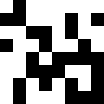

In [359]:
N = 8
dx = 2
state = bitrand(N, N)
filter = zeros(Complex, N, N);
drow(state)

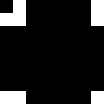

In [360]:
IDX(x, y) = ( (x + N) % N ) + ( (y+N) % N ) * N + 1
    filter[IDX(-1, -1)] = 1. ;
    filter[IDX( 0, -1)] = 1. ;
    filter[IDX( 1, -1)] = 1. ;
    filter[IDX(-1,  0)] = 1. ;
    filter[IDX( 1,  0)] = 1. ;
    filter[IDX(-1,  1)] = 1. ;
    filter[IDX( 0,  1)] = 1. ;
    filter[IDX( 1,  1)] = 1. ;
drow(filter)

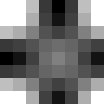

In [361]:
filter = fft( real.(filter) )
drow(filter)

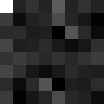

In [362]:
tmp = fft( real.(state) ) # fwd
drow(tmp)

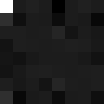

In [363]:
tmp .*= filter
drow(tmp)

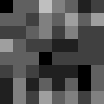

In [364]:
summ = ifft(tmp) # rev
drow(summ)

In [80]:
128>>2

32

In [365]:
round.(Int, real.(summ)) .>> 2

8×8 Array{Int64,2}:
 0  1  1  2  1  1  0  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  0  0  1  1
 1  1  1  0  1  1  1  1
 1  1  1  0  0  0  0  1
 0  1  0  1  0  1  0  1
 0  1  1  1  1  1  1  1

2547543355455566545454348664235765434335576343563544422447444556

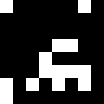

In [366]:
tmp = fft( real.(state) ) # fwd
tmp .*= filter

summ = ifft(tmp) # rev

for i in eachindex(state)
    t = round( Int, real(summ[i]) ) >> 0
    print(t)
    state[i] = ( state[i] ? t == 2 || t == 3 : t == 3 )
end
drow(state)

In [373]:
cd("C:\\Users\\User\\Desktop\\Mycop\\plots")

In [368]:
function makefilter(N::Int64)
    filter = zeros(Complex, N, N);
    IDX(x, y) = ( (x + N) % N ) + ( (y+N) % N ) * N + 1
        filter[IDX(-1, -1)] = 1. ;
        filter[IDX( 0, -1)] = 1. ;
        filter[IDX( 1, -1)] = 1. ;
        filter[IDX(-1,  0)] = 1. ;
        filter[IDX( 1,  0)] = 1. ;
        filter[IDX(-1,  1)] = 1. ;
        filter[IDX( 0,  1)] = 1. ;
        filter[IDX( 1,  1)] = 1. ;
    
    return fft( real.(filter) )
end

makefilter (generic function with 1 method)

In [379]:
function fftlife(N = 16, steps = 100, dx = 0, glider = true)

    if glider
        state = falses(N, N)
        state[4,5] = state[5,6] = state[6,6] = true
        state[6,5] = state[6,4] = true
    else
        state = bitrand(N, N)
    end
    
    filter = makefilter(N)
    
    for i in 1:steps
        tmp = fft( real.(state) ) # forward
        tmp .*= filter

        summ = ifft(tmp) # reverse

        for i in eachindex(state)
            t = round( Int, real(summ[i]) ) >> dx
            state[i] = ( state[i] ? t == 2 || t == 3 : t == 3 )
        end
        save("KonLife_$(N)x$(N)_$i.png", kron( Gray.(state), ones(8,8) ) )
    end
    
end

fftlife (generic function with 5 methods)

In [380]:
fftlife(16, 60)